In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
from scipy.optimize import minimize
from scipy.stats import norm
from scipy import integrate

In [3]:
def function_H(T):
    return 1-norm.cdf(T)

def function_in_G(h,x,T):
    
    return np.exp(-h**2/2)*function_H( ((1-x)*h-T) / np.sqrt(x*(2-x)) )/np.sqrt(2*np.pi)

def function_G(delta_s,f,T):
    
    Int_res, err = integrate.quad(function_in_G,T,np.inf,args=(delta_s,T))
    
    return Int_res/(f*(1-f))

def function_in_I(h1,h2,delta):
    
    return np.exp( -0.5*h1**2 - 0.5*h2**2 + 0.5*(1-delta)*h1*h2 ) / (2*np.pi)
    
def function_I(T,delta):
    
    T_delta = T / np.sqrt(1-0.25*(1-delta)**2)
    
    
    Int_res, err = integrate.dblquad(function_in_I, T_delta, np.inf, lambda h1: T_delta, lambda h1: np.inf, args=(delta,))
    
    return Int_res


def function_in_g(h1,h2,delta):
    
    return h1*h2*np.exp( -0.5*h1**2 - 0.5*h2**2 + 0.5*(1-delta)*h1*h2 ) / (2*np.pi)


def function_g(T,delta):
    
    T_delta = T / np.sqrt(1-0.25*(1-delta)**2)
    
    
    Int_res, err = integrate.dblquad(function_in_g, T_delta, np.inf, lambda h1: T_delta, lambda h1: np.inf, args=(delta,))
    
    return Int_res

def s_delta(delta):
    
    return np.sqrt(1 - 0.25*(1-delta)**2)

In [4]:
def signal_coeff(f,T,delta_sigma,delta_eta):
    
    delta_mix = (delta_sigma + delta_eta) / 2.
    G1 = function_G(delta_sigma,f,T)
    G2 = function_G(delta_eta,f,T)
    G3 = function_G(delta_mix,f,T)
    
    return G1**2, G2**2, G3**2, 2*G1*G2, 2*G1*G3, 2*G2*G3, -2*G1, -2*G2, -2*G3

def part3_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta):
    
    delta_mix = (delta_sigma + delta_eta) / 2.
    G1 = function_G(delta_sigma,f,T)
    G2 = function_G(delta_eta,f,T)
    G3 = function_G(delta_mix,f,T)
    
    s1 = s_delta(delta_sigma)
    s2 = s_delta(delta_eta)
    
    I1 = function_I(T, delta_sigma)
    I2 = function_I(T, delta_eta)
    
    C0 = (1/Nc) * (P*K-1)* (f**2) * (1-f)**2 
    A = (1/Nc) * (2*f-1)**2 * (K-1) * f * (1-f) * (1-G1)
    B = (1/Nc) * (2*f-1)**2 * (P-1) * f * (1-f) * (1-G2)
    
    C = (1/Nc) * (2*f-1)**2 * (K-1) * s1 * I1 + (1/Nc) * (2*f-1)**2 * (P-1) * s2 * I2 - (1/Nc) * (2*f-1)**2 * f**2 * (P+K-2)
    
    return C0, A, B, C


def part4_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta):
    
    delta_mix = (delta_sigma + delta_eta) / 2.
    G1 = function_G(delta_sigma,f,T)
    G2 = function_G(delta_eta,f,T)
    G3 = function_G(delta_mix,f,T)
    
    s1 = s_delta(delta_sigma)
    s2 = s_delta(delta_eta)
    
    I1 = function_I(T, delta_sigma)
    I2 = function_I(T, delta_eta)
    
    g1 = function_g(T, delta_sigma)
    g2 = function_g(T, delta_eta)
    
    
    D = (K-1) * (f**2) * (1-f)**2 * (1-G1)**2 + (P*K-K) * (1/N) * (np.exp(-2*T**2)/(2*np.pi)**2) 
    E = (P-1) * (f**2) * (1-f)**2 * (1-G2)**2 + (P*K-P) * (1/M) * (np.exp(-2*T**2)/(2*np.pi)**2) 
    
    F1 = (K-1) * ( (s1*I1 - f**2)**2 + s1**2 * g1**2 * (1/(4*M)) )
    F2 = (P-1) * ( (s2*I2 - f**2)**2 + s2**2 * g2**2 * (1/(4*N)) )
    F3 = (P*K-P-K+1) * ( 1/(4*M) + 1/(4*N) ) * (np.exp(-2*T**2)/(2*np.pi)**2)
    
    R1 = (K-1) * (s1*I1 - f**2) * (1-G1) * f * (1-f)
    R2 = (P-1) * s2 * g2 * (1/(2*N)) * (np.exp(-T**2)/(2*np.pi)) 
    R3 = (P*K - P - K  + 1) * (1/(2*N)) * (np.exp(-2*T**2)/(2*np.pi)**2)
    
    S1 = (P-1) * (s2*I2 - f**2) * (1-G2) * f * (1-f)
    S2 = (K-1) * s1 * g1 * (1/(2*M)) * (np.exp(-T**2)/(2*np.pi)) 
    S3 = (P*K - P - K  + 1) * (1/(2*M)) * (np.exp(-2*T**2)/(2*np.pi)**2)
    
    return D, E, F1+F2+F3, R1+R2+R3, S1+S2+S3


def minus_SNR_p(p):
    
    p1, p2, p3 = p
    
    signal  = f**2 * (1-f)**2 * ( sig_coeff[0]*(p1**2) + sig_coeff[1]*(p2**2) + sig_coeff[2]*(p3**2) + 
                                sig_coeff[3]*p1*p2 + sig_coeff[4]*p1*p3 + sig_coeff[5]*p2*p3 
                                + sig_coeff[6]*p1 + sig_coeff[7]*p2 + sig_coeff[8]*p3 + 1)
    
    part3 = C0 + A*p1 + B*p2 + C*p3
    
    part4 = D*p1*p1 + E*p2*p2 + F*p3*p3 + 2*R*p1*p3 + 2*S*p2*p3
    
    return -signal/(part3+part4)

### 1. Function of Sparseness

In [5]:
K = 20
delta_eta=0.3
N = 100
M = 100
Nc = 10000
f= 0.05
T = norm.ppf(1-f)

P_list = np.linspace(2,80,40,dtype=np.int)
DeltaSigma_list = np.linspace(0.03,0.8,40)


# Constrain Argument 
e = 1e-10 # close to zero
cons = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] + x[2] - 1}, # x+y+z=1
        {'type': 'ineq', 'fun': lambda x: x[0] - e}, # x>=e, s.t. x > 0
        {'type': 'ineq', 'fun': lambda x: x[1] - e},
        {'type': 'ineq', 'fun': lambda x: x[2] - e}
       )
p0 = np.array((0.4, 0.6, 0.0)) # initial value


#P, delta_sigma, min_value, p1, p2 , p2, success? 
Record_best = np.full((1600,7),-1.)
count = 0

for P in tqdm(P_list):
    for delta_sigma in DeltaSigma_list:
        
        # Calculate Coefficients First
        sig_coeff = signal_coeff(f, T, delta_sigma, delta_eta)
        C0, A, B, C = part3_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta)
        D, E, F, R, S = part4_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta)
        
        # Run the Optimization Procedue 
        res = minimize(minus_SNR_p, p0, method='SLSQP', constraints=cons, tol=1e-6)
        
        Record_best[count,0] = P
        Record_best[count,1] = delta_sigma 
        Record_best[count,2] = function_H(np.sqrt(-res.fun))
        Record_best[count,3:6] = res.x.round(3)
        Record_best[count,6] = res.success
        
        count = count + 1

In [74]:
color1='#1f78b4'
color2='#a6cee3'
color3='#b2df8a'
color4='#33a02c'
color5='#fdbf6f'

In [61]:
color1='#fc8d62'
color2='#8da0cb'
color3='#66c2a5'

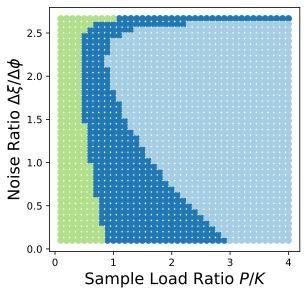

In [85]:
display.set_matplotlib_formats('svg')
plt.figure(figsize=[4.5,4.5])
w0 = np.argwhere(Record_best[:,5] == 1).reshape(-1)
w1 = np.argwhere((Record_best[:,3] > 0) & (Record_best[:,4] == 0)).reshape(-1)
w2 = np.argwhere((Record_best[:,3] == 0) & (Record_best[:,4] > 0)).reshape(-1)
w3 = np.argwhere((Record_best[:,3] > 0) & (Record_best[:,4] > 0) & (Record_best[:,5] > 0)).reshape(-1)
w4 = np.argwhere((Record_best[:,3] > 0) & (Record_best[:,4] > 0) & (Record_best[:,5] == 0)).reshape(-1)

plt.plot(Record_best[w0,0]/20,Record_best[w0,1]/0.3, 'o', c=color1, label = r'$p3=1.0$, all mixed')
plt.plot(Record_best[w1,0]/20,Record_best[w1,1]/0.3, 'o', c=color2, label = r'$p1,p3>0, p2=0$')
plt.plot(Record_best[w2,0]/20,Record_best[w2,1]/0.3, 'o', c=color3, label = r'$p2,p3>0, p1=0$')

if w4.shape != 0:
    plt.plot(Record_best[w4,0]/20,Record_best[w4,1]/0.3, 'o', c=color4, label = r'$p1,p2>0, p3=0$')

if w3.shape != 0:
    plt.plot(Record_best[w3,0]/20,Record_best[w3,1]/0.3, 'o', c=color5, label = r'$p1,p2,p3>0$')

plt.xlabel(r'Sample Load Ratio $P/K$',fontsize=16)
plt.ylabel(r'Noise Ratio $\Delta \xi / \Delta \phi$', fontsize=16)
#plt.xscale('log')
#plt.yscale('log')
#plt.title('N=M=100,Nc=10000,f=0.05,$K=20, \Delta \phi=0.3$')
#plt.legend(ncol=5,bbox_to_anchor=[1.5,1.2],frameon=False)
plt.savefig('sparseness1.png',transparent=True,dpi=200,bbox_inches='tight')
plt.show()

In [8]:
K = 20
delta_eta=0.3
N = 100
M = 100
Nc = 10000
f= 0.005
T = norm.ppf(1-f)

P_list = np.linspace(2,80,40,dtype=np.int)
DeltaSigma_list = np.linspace(0.03,0.8,40)


# Constrain Argument 
e = 1e-10 # close to zero
cons = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] + x[2] - 1}, # x+y+z=1
        {'type': 'ineq', 'fun': lambda x: x[0] - e}, # x>=e, s.t. x > 0
        {'type': 'ineq', 'fun': lambda x: x[1] - e},
        {'type': 'ineq', 'fun': lambda x: x[2] - e}
       )
p0 = np.array((0.4, 0.6, 0.0)) # initial value


#P, delta_sigma, min_value, p1, p2 , p2, success? 
Record_best1 = np.full((1600,7),-1.)
count = 0

for P in tqdm(P_list):
    for delta_sigma in DeltaSigma_list:
        
        # Calculate Coefficients First
        sig_coeff = signal_coeff(f, T, delta_sigma, delta_eta)
        C0, A, B, C = part3_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta)
        D, E, F, R, S = part4_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta)
        
        # Run the Optimization Procedue 
        res = minimize(minus_SNR_p, p0, method='SLSQP', constraints=cons, tol=1e-6)
        
        Record_best1[count,0] = P
        Record_best1[count,1] = delta_sigma 
        Record_best1[count,2] = function_H(np.sqrt(-res.fun))
        Record_best1[count,3:6] = res.x.round(3)
        Record_best1[count,6] = res.success
        
        count = count + 1

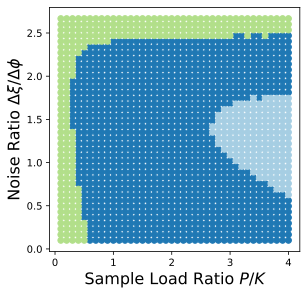

In [76]:
display.set_matplotlib_formats('svg')
plt.figure(figsize=[4.5,4.5])
w0 = np.argwhere(Record_best1[:,5] == 1).reshape(-1)
w1 = np.argwhere((Record_best1[:,3] > 0) & (Record_best1[:,4] == 0)).reshape(-1)
w2 = np.argwhere((Record_best1[:,3] == 0) & (Record_best1[:,4] > 0)).reshape(-1)
w3 = np.argwhere((Record_best1[:,3] > 0) & (Record_best1[:,4] > 0) & (Record_best1[:,5] > 0)).reshape(-1)
w4 = np.argwhere((Record_best1[:,3] > 0) & (Record_best1[:,4] > 0) & (Record_best1[:,5] == 0)).reshape(-1)

plt.plot(Record_best1[w0,0]/20,Record_best1[w0,1]/0.3, 'o', c=color1, label = r'$p3=1.0$, all mixed')
plt.plot(Record_best1[w1,0]/20,Record_best1[w1,1]/0.3, 'o', c=color2, label = r'$p1>0, p2=0$')
plt.plot(Record_best1[w2,0]/20,Record_best1[w2,1]/0.3, 'o', c=color3, label = r'$p2>0, p1=0$')

if w4.shape != 0:
    plt.plot(Record_best1[w4,0]/20,Record_best1[w4,1]/0.3, 'o', c='grey', label = r'$p1,p2>0, p3=0$')

if w3.shape != 0:
    plt.plot(Record_best1[w3,0]/20,Record_best1[w3,1]/0.3, 'o', c='black', label = r'$p1,p2,p3>0$')

plt.xlabel(r'Sample Load Ratio $P/K$',fontsize=16)
plt.ylabel(r'Noise Ratio $\Delta \xi / \Delta \phi$', fontsize=16)
#plt.xscale('log')
#plt.yscale('log')
#plt.title('N=M=100,Nc=10000,f=0.05,$K=20, \Delta \phi=0.3$')
#plt.legend(ncol=5,bbox_to_anchor=[1.5,1.2],frameon=False)
plt.savefig('sparseness2.png',transparent=True,dpi=200,bbox_inches='tight')
plt.show()

In [9]:
K = 20
delta_eta=0.3
N = 100
M = 100
Nc = 10000
f= 0.5
T = norm.ppf(1-f)

P_list = np.linspace(2,80,40,dtype=np.int)
DeltaSigma_list = np.linspace(0.03,0.8,40)


# Constrain Argument 
e = 1e-10 # close to zero
cons = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] + x[2] - 1}, # x+y+z=1
        {'type': 'ineq', 'fun': lambda x: x[0] - e}, # x>=e, s.t. x > 0
        {'type': 'ineq', 'fun': lambda x: x[1] - e},
        {'type': 'ineq', 'fun': lambda x: x[2] - e}
       )
p0 = np.array((0.4, 0.6, 0.0)) # initial value


#P, delta_sigma, min_value, p1, p2 , p2, success? 
Record_best2 = np.full((1600,7),-1.)
count = 0

for P in tqdm(P_list):
    for delta_sigma in DeltaSigma_list:
        
        # Calculate Coefficients First
        sig_coeff = signal_coeff(f, T, delta_sigma, delta_eta)
        C0, A, B, C = part3_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta)
        D, E, F, R, S = part4_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta)
        
        # Run the Optimization Procedue 
        res = minimize(minus_SNR_p, p0, method='SLSQP', constraints=cons, tol=1e-6)
        
        Record_best2[count,0] = P
        Record_best2[count,1] = delta_sigma 
        Record_best2[count,2] = function_H(np.sqrt(-res.fun))
        Record_best2[count,3:6] = res.x.round(3)
        Record_best2[count,6] = res.success
        
        count = count + 1

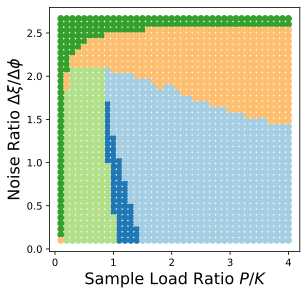

In [77]:
display.set_matplotlib_formats('svg')
plt.figure(figsize=[4.5,4.5])
w0 = np.argwhere(Record_best2[:,5] == 1).reshape(-1)
w1 = np.argwhere((Record_best2[:,3] > 0) & (Record_best2[:,4] == 0)).reshape(-1)
w2 = np.argwhere((Record_best2[:,3] == 0) & (Record_best2[:,4] > 0)).reshape(-1)
w3 = np.argwhere((Record_best2[:,3] > 0) & (Record_best2[:,4] > 0) & (Record_best2[:,5] > 0)).reshape(-1)
w4 = np.argwhere((Record_best2[:,3] > 0) & (Record_best2[:,4] > 0) & (Record_best2[:,5] == 0)).reshape(-1)

plt.plot(Record_best2[w0,0]/20,Record_best2[w0,1]/0.3, 'o', c=color1, label = r'$p3=1.0$, all mixed')
plt.plot(Record_best2[w1,0]/20,Record_best2[w1,1]/0.3, 'o', c=color2, label = r'$p1>0, p2=0$')
plt.plot(Record_best2[w2,0]/20,Record_best2[w2,1]/0.3, 'o', c=color3, label = r'$p2>0, p1=0$')

if w4.shape != 0:
    plt.plot(Record_best2[w4,0]/20,Record_best2[w4,1]/0.3, 'o', c=color4, label = r'$p1,p2>0, p3=0$')

if w3.shape != 0:
    plt.plot(Record_best2[w3,0]/20,Record_best2[w3,1]/0.3, 'o', c=color5, label = r'$p1,p2,p3>0$')

plt.xlabel(r'Sample Load Ratio $P/K$',fontsize=16)
plt.ylabel(r'Noise Ratio $\Delta \xi / \Delta \phi$', fontsize=16)
#plt.xscale('log')
#plt.yscale('log')
#plt.title('N=M=100,Nc=10000,f=0.05,$K=20, \Delta \phi=0.3$')
#plt.legend(ncol=5,bbox_to_anchor=[1.5,1.2],frameon=False)
plt.savefig('sparseness3.png',transparent=True,dpi=200,bbox_inches='tight')
plt.show()

### 2. Function of Expansion

In [10]:
K = 20
delta_eta=0.3
N = 100
M = 100
Nc = 5000
f= 0.05
T = norm.ppf(1-f)

P_list = np.linspace(2,80,40,dtype=np.int)
DeltaSigma_list = np.linspace(0.03,0.8,40)


# Constrain Argument 
e = 1e-10 # close to zero
cons = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] + x[2] - 1}, # x+y+z=1
        {'type': 'ineq', 'fun': lambda x: x[0] - e}, # x>=e, s.t. x > 0
        {'type': 'ineq', 'fun': lambda x: x[1] - e},
        {'type': 'ineq', 'fun': lambda x: x[2] - e}
       )
p0 = np.array((0.4, 0.6, 0.0)) # initial value


#P, delta_sigma, min_value, p1, p2 , p2, success? 
Record_best3 = np.full((1600,7),-1.)
count = 0

for P in tqdm(P_list):
    for delta_sigma in DeltaSigma_list:
        
        # Calculate Coefficients First
        sig_coeff = signal_coeff(f, T, delta_sigma, delta_eta)
        C0, A, B, C = part3_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta)
        D, E, F, R, S = part4_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta)
        
        # Run the Optimization Procedue 
        res = minimize(minus_SNR_p, p0, method='SLSQP', constraints=cons, tol=1e-6)
        
        Record_best3[count,0] = P
        Record_best3[count,1] = delta_sigma 
        Record_best3[count,2] = function_H(np.sqrt(-res.fun))
        Record_best3[count,3:6] = res.x.round(3)
        Record_best3[count,6] = res.success
        
        count = count + 1

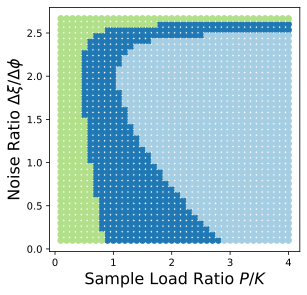

In [79]:
display.set_matplotlib_formats('svg')
plt.figure(figsize=[4.5,4.5])
w0 = np.argwhere(Record_best3[:,5] == 1).reshape(-1)
w1 = np.argwhere((Record_best3[:,3] > 0) & (Record_best3[:,4] == 0)).reshape(-1)
w2 = np.argwhere((Record_best3[:,3] == 0) & (Record_best3[:,4] > 0)).reshape(-1)
w3 = np.argwhere((Record_best3[:,3] > 0) & (Record_best3[:,4] > 0) & (Record_best3[:,5] > 0)).reshape(-1)
w4 = np.argwhere((Record_best3[:,3] > 0) & (Record_best3[:,4] > 0) & (Record_best3[:,5] == 0)).reshape(-1)

plt.plot(Record_best3[w0,0]/20,Record_best3[w0,1]/0.3, 'o', c=color1, label = r'$p3=1.0$, all mixed')
plt.plot(Record_best3[w1,0]/20,Record_best3[w1,1]/0.3, 'o', c=color2, label = r'$p1>0, p2=0$')
plt.plot(Record_best3[w2,0]/20,Record_best3[w2,1]/0.3, 'o', c=color3, label = r'$p2>0, p1=0$')

if w4.shape != 0:
    plt.plot(Record_best3[w4,0]/20,Record_best3[w4,1]/0.3, 'o', c='grey', label = r'$p1,p2>0, p3=0$')

if w3.shape != 0:
    plt.plot(Record_best3[w3,0]/20,Record_best3[w3,1]/0.3, 'o', c='black', label = r'$p1,p2,p3>0$')

plt.xlabel(r'Sample Load Ratio $P/K$',fontsize=16)
plt.ylabel(r'Noise Ratio $\Delta \xi / \Delta \phi$', fontsize=16)
#plt.xscale('log')
#plt.yscale('log')
#plt.title('N=M=100,Nc=10000,f=0.05,$K=20, \Delta \phi=0.3$')
#plt.legend(ncol=5,bbox_to_anchor=[1.5,1.2],frameon=False)
plt.savefig('expansion1.png',transparent=True,dpi=200,bbox_inches='tight')
plt.show()

In [11]:
K = 20
delta_eta=0.3
N = 100
M = 100
Nc = 500
f= 0.05
T = norm.ppf(1-f)

P_list = np.linspace(2,80,40,dtype=np.int)
DeltaSigma_list = np.linspace(0.03,0.8,40)


# Constrain Argument 
e = 1e-10 # close to zero
cons = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] + x[2] - 1}, # x+y+z=1
        {'type': 'ineq', 'fun': lambda x: x[0] - e}, # x>=e, s.t. x > 0
        {'type': 'ineq', 'fun': lambda x: x[1] - e},
        {'type': 'ineq', 'fun': lambda x: x[2] - e}
       )
p0 = np.array((0.4, 0.6, 0.0)) # initial value


#P, delta_sigma, min_value, p1, p2 , p2, success? 
Record_best4 = np.full((1600,7),-1.)
count = 0

for P in tqdm(P_list):
    for delta_sigma in DeltaSigma_list:
        
        # Calculate Coefficients First
        sig_coeff = signal_coeff(f, T, delta_sigma, delta_eta)
        C0, A, B, C = part3_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta)
        D, E, F, R, S = part4_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta)
        
        # Run the Optimization Procedue 
        res = minimize(minus_SNR_p, p0, method='SLSQP', constraints=cons, tol=1e-6)
        
        Record_best4[count,0] = P
        Record_best4[count,1] = delta_sigma 
        Record_best4[count,2] = function_H(np.sqrt(-res.fun))
        Record_best4[count,3:6] = res.x.round(3)
        Record_best4[count,6] = res.success
        
        count = count + 1

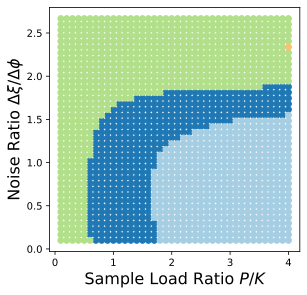

In [84]:
display.set_matplotlib_formats('svg')
plt.figure(figsize=[4.5,4.5])
w0 = np.argwhere(Record_best4[:,5] == 1).reshape(-1)
w1 = np.argwhere((Record_best4[:,3] > 0) & (Record_best4[:,4] == 0)).reshape(-1)
w2 = np.argwhere((Record_best4[:,3] == 0) & (Record_best4[:,4] > 0)).reshape(-1)
w3 = np.argwhere((Record_best4[:,3] > 0) & (Record_best4[:,4] > 0) & (Record_best4[:,5] > 0)).reshape(-1)
w4 = np.argwhere((Record_best4[:,3] > 0) & (Record_best4[:,4] > 0) & (Record_best4[:,5] == 0)).reshape(-1)

plt.plot(Record_best4[w0,0]/20,Record_best4[w0,1]/0.3, 'o', c=color1, label = r'$p3=1.0$, all mixed')
plt.plot(Record_best4[w1,0]/20,Record_best4[w1,1]/0.3, 'o', c=color2, label = r'$p1>0, p2=0$')
plt.plot(Record_best4[w2,0]/20,Record_best4[w2,1]/0.3, 'o', c=color3, label = r'$p2>0, p1=0$')

if w4.shape != 0:
    plt.plot(Record_best4[w4,0]/20,Record_best4[w4,1]/0.3, 'o', c=color4, label = r'$p1,p2>0, p3=0$')

if w3.shape != 0:
    plt.plot(Record_best4[w3,0]/20,Record_best4[w3,1]/0.3, 'o', c=color5, label = r'$p1,p2,p3>0$')

plt.xlabel(r'Sample Load Ratio $P/K$',fontsize=16)
plt.ylabel(r'Noise Ratio $\Delta \xi / \Delta \phi$', fontsize=16)
#plt.xscale('log')
#plt.yscale('log')
#plt.title('N=M=100,Nc=10000,f=0.05,$K=20, \Delta \phi=0.3$')
#plt.legend(ncol=5,bbox_to_anchor=[1.5,1.2],frameon=False)
plt.savefig('expansion2.png',transparent=True,dpi=200,bbox_inches='tight')
plt.show()

In [12]:
K = 20
delta_eta=0.3
N = 100
M = 100
Nc = 50000
f= 0.05
T = norm.ppf(1-f)

P_list = np.linspace(2,80,40,dtype=np.int)
DeltaSigma_list = np.linspace(0.03,0.8,40)


# Constrain Argument 
e = 1e-10 # close to zero
cons = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] + x[2] - 1}, # x+y+z=1
        {'type': 'ineq', 'fun': lambda x: x[0] - e}, # x>=e, s.t. x > 0
        {'type': 'ineq', 'fun': lambda x: x[1] - e},
        {'type': 'ineq', 'fun': lambda x: x[2] - e}
       )
p0 = np.array((0.4, 0.6, 0.0)) # initial value


#P, delta_sigma, min_value, p1, p2 , p2, success? 
Record_best5 = np.full((1600,7),-1.)
count = 0

for P in tqdm(P_list):
    for delta_sigma in DeltaSigma_list:
        
        # Calculate Coefficients First
        sig_coeff = signal_coeff(f, T, delta_sigma, delta_eta)
        C0, A, B, C = part3_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta)
        D, E, F, R, S = part4_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta)
        
        # Run the Optimization Procedue 
        res = minimize(minus_SNR_p, p0, method='SLSQP', constraints=cons, tol=1e-6)
        
        Record_best5[count,0] = P
        Record_best5[count,1] = delta_sigma 
        Record_best5[count,2] = function_H(np.sqrt(-res.fun))
        Record_best5[count,3:6] = res.x.round(3)
        Record_best5[count,6] = res.success
        
        count = count + 1

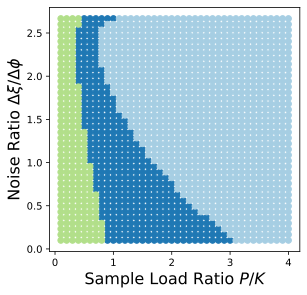

In [83]:
display.set_matplotlib_formats('svg')
plt.figure(figsize=[4.5,4.5])
w0 = np.argwhere(Record_best5[:,5] == 1).reshape(-1)
w1 = np.argwhere((Record_best5[:,3] > 0) & (Record_best5[:,4] == 0)).reshape(-1)
w2 = np.argwhere((Record_best5[:,3] == 0) & (Record_best5[:,4] > 0)).reshape(-1)
w3 = np.argwhere((Record_best5[:,3] > 0) & (Record_best5[:,4] > 0) & (Record_best5[:,5] > 0)).reshape(-1)
w4 = np.argwhere((Record_best5[:,3] > 0) & (Record_best5[:,4] > 0) & (Record_best5[:,5] == 0)).reshape(-1)

plt.plot(Record_best5[w0,0]/20,Record_best5[w0,1]/0.3, 'o', c=color1, label = r'$p3=1.0$, all mixed')
plt.plot(Record_best5[w1,0]/20,Record_best5[w1,1]/0.3, 'o', c=color2, label = r'$p1>0, p2=0$')
plt.plot(Record_best5[w2,0]/20,Record_best5[w2,1]/0.3, 'o', c=color3, label = r'$p2>0, p1=0$')

if w4.shape != 0:
    plt.plot(Record_best5[w4,0]/20,Record_best5[w4,1]/0.3, 'o', c=color4, label = r'$p1,p2>0, p3=0$')

if w3.shape != 0:
    plt.plot(Record_best5[w3,0]/20,Record_best5[w3,1]/0.3, 'o', c=color5, label = r'$p1,p2,p3>0$')

plt.xlabel(r'Sample Load Ratio $P/K$',fontsize=16)
plt.ylabel(r'Noise Ratio $\Delta \xi / \Delta \phi$', fontsize=16)
#plt.xscale('log')
#plt.yscale('log')
#plt.title('N=M=100,Nc=10000,f=0.05,$K=20, \Delta \phi=0.3$')
#plt.legend(ncol=5,bbox_to_anchor=[1.5,1.2],frameon=False)
plt.savefig('expansion3.png',transparent=True,dpi=200,bbox_inches='tight')
plt.show()

### 3. An experiment-related setting

In [40]:
K = 20
delta_eta=0.3
N = 1000
M = 1000
Nc = 500000
f= 0.05
T = norm.ppf(1-f)

P_list = np.linspace(2,80,40,dtype=np.int)
DeltaSigma_list = np.linspace(0.03,0.8,40)


# Constrain Argument 
e = 1e-10 # close to zero
cons = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] + x[2] - 1}, # x+y+z=1
        {'type': 'ineq', 'fun': lambda x: x[0] - e}, # x>=e, s.t. x > 0
        {'type': 'ineq', 'fun': lambda x: x[1] - e},
        {'type': 'ineq', 'fun': lambda x: x[2] - e}
       )
p0 = np.array((0.4, 0.6, 0.0)) # initial value


#P, delta_sigma, min_value, p1, p2 , p2, success? 
Record_best6 = np.full((1600,7),-1.)
count = 0

for P in tqdm(P_list):
    for delta_sigma in DeltaSigma_list:
        
        # Calculate Coefficients First
        sig_coeff = signal_coeff(f, T, delta_sigma, delta_eta)
        C0, A, B, C = part3_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta)
        D, E, F, R, S = part4_coeff(Nc,N,M,P,K,f,T,delta_sigma,delta_eta)
        
        # Run the Optimization Procedue 
        res = minimize(minus_SNR_p, p0, method='SLSQP', constraints=cons, tol=1e-6)
        
        Record_best6[count,0] = P
        Record_best6[count,1] = delta_sigma 
        Record_best6[count,2] = function_H(np.sqrt(-res.fun))
        Record_best6[count,3:6] = res.x.round(3)
        Record_best6[count,6] = res.success
        
        count = count + 1

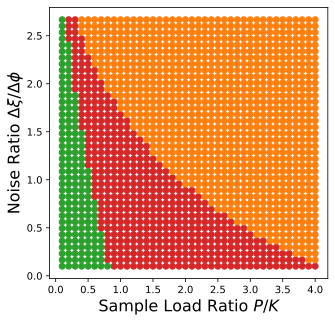

In [41]:
display.set_matplotlib_formats('svg')
plt.figure(figsize=[5,5])
w0 = np.argwhere(Record_best6[:,5] == 1).reshape(-1)
w1 = np.argwhere((Record_best6[:,3] > 0) & (Record_best6[:,4] == 0)).reshape(-1)
w2 = np.argwhere((Record_best6[:,3] == 0) & (Record_best6[:,4] > 0)).reshape(-1)
w3 = np.argwhere((Record_best6[:,3] > 0) & (Record_best6[:,4] > 0) & (Record_best6[:,5] > 0)).reshape(-1)
w4 = np.argwhere((Record_best6[:,3] > 0) & (Record_best6[:,4] > 0) & (Record_best6[:,5] == 0)).reshape(-1)

plt.plot(Record_best6[w0,0]/20,Record_best6[w0,1]/0.3, 'o', c='tab:red', label = r'$p3=1.0$, all mixed')
plt.plot(Record_best6[w1,0]/20,Record_best6[w1,1]/0.3, 'o', c='tab:orange', label = r'$p1>0, p2=0$')
plt.plot(Record_best6[w2,0]/20,Record_best6[w2,1]/0.3, 'o', c='tab:green', label = r'$p2>0, p1=0$')

if w4.shape != 0:
    plt.plot(Record_best6[w4,0]/20,Record_best6[w4,1]/0.3, 'o', c='grey', label = r'$p1,p2>0, p3=0$')

if w3.shape != 0:
    plt.plot(Record_best6[w3,0]/20,Record_best6[w3,1]/0.3, 'o', c='black', label = r'$p1,p2,p3>0$')

plt.xlabel(r'Sample Load Ratio $P/K$',fontsize=16)
plt.ylabel(r'Noise Ratio $\Delta \xi / \Delta \phi$', fontsize=16)
#plt.xscale('log')
#plt.yscale('log')
#plt.title('N=M=100,Nc=10000,f=0.05,$K=20, \Delta \phi=0.3$')
#plt.legend(ncol=5,bbox_to_anchor=[1.5,1.2],frameon=False)
plt.savefig('experiment_setting.png',transparent=True,dpi=200,bbox_inches='tight')
plt.show()